## Understanding and Predicting Property Maintenance Fines


We provide you with two data files for use in training and validating your models: train.csv and test.csv. Each row in these two files corresponds to a single blight ticket, and includes information about when, why, and to whom each ticket was issued. The target variable is compliance, which is True if the ticket was paid early, on time, or within one month of the hearing data, False if the ticket was paid after the hearing date or not at all, and Null if the violator was found not responsible. Compliance, as well as a handful of other variables that will not be available at test-time, are only included in train.csv.

Note: All tickets where the violators were found not responsible are not considered during evaluation. They are included in the training set as an additional source of data for visualization, and to enable unsupervised and semi-supervised approaches. However, they are not included in the test set.

<br>

**File descriptions** (Use only this data for training your model!)

    readonly/train.csv - the training set (all tickets issued 2004-2011)
    readonly/test.csv - the test set (all tickets issued 2012-2016)
    readonly/addresses.csv & readonly/latlons.csv - mapping from ticket id to addresses, and from addresses to lat/lon coordinates. 
     Note: misspelled addresses may be incorrectly geolocated.

<br>

**Data fields**

train.csv & test.csv

    ticket_id - unique identifier for tickets
    agency_name - Agency that issued the ticket
    inspector_name - Name of inspector that issued the ticket
    violator_name - Name of the person/organization that the ticket was issued to
    violation_street_number, violation_street_name, violation_zip_code - Address where the violation occurred
    mailing_address_str_number, mailing_address_str_name, city, state, zip_code, non_us_str_code, country - Mailing address of the violator
    ticket_issued_date - Date and time the ticket was issued
    hearing_date - Date and time the violator's hearing was scheduled
    violation_code, violation_description - Type of violation
    disposition - Judgment and judgement type
    fine_amount - Violation fine amount, excluding fees
    admin_fee - $20 fee assigned to responsible judgments
state_fee - $10 fee assigned to responsible judgments
    late_fee - 10% fee assigned to responsible judgments
    discount_amount - discount applied, if any
    clean_up_cost - DPW clean-up or graffiti removal cost
    judgment_amount - Sum of all fines and fees
    grafitti_status - Flag for graffiti violations
    
train.csv only

    payment_amount - Amount paid, if any
    payment_date - Date payment was made, if it was received
    payment_status - Current payment status as of Feb 1 2017
    balance_due - Fines and fees still owed
    collection_status - Flag for payments in collections
    compliance [target variable for prediction] 
     Null = Not responsible
     0 = Responsible, non-compliant
     1 = Responsible, compliant
    compliance_detail - More information on why each ticket was marked compliant or non-compliant


___

## Evaluation

Your predictions will be given as the probability that the corresponding blight ticket will be paid on time.

The evaluation metric for this assignment is the Area Under the ROC Curve (AUC). 

Your grade will be based on the AUC score computed for your classifier. A model which with an AUROC of 0.7 passes this assignment, over 0.75 will recieve full points.
___

For this assignment, create a function that trains a model to predict blight ticket compliance in Detroit using `readonly/train.csv`. Using this model, return a series of length 61001 with the data being the probability that each corresponding ticket from `readonly/test.csv` will be paid, and the index being the ticket_id.

Example:

    ticket_id
       284932    0.531842
       285362    0.401958
       285361    0.105928
       285338    0.018572
                 ...
       376499    0.208567
       376500    0.818759
       369851    0.018528
       Name: compliance, dtype: float32
       

## Load the data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
def load_data():
    df_train = pd.read_csv('dataset/train.csv', encoding = "ISO-8859-1")
    df_test = pd.read_csv('dataset/test.csv', encoding = "ISO-8859-1")

    return df_train, df_test

In [3]:
df_train, df_test = load_data();

/usr/local/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3337: DtypeWarning: Columns (11,12,31) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


### 1). Remove some variables to prevent potential data leakage:
 - collection_status - Flag for payments in collections
 - compliance_detail - More information on why each ticket was marked compliant or non-compliant
 - information only given in training data set

In [4]:
df_train.drop(["collection_status", "compliance_detail"], axis=1, inplace=True)
df_train.drop(["balance_due", "payment_amount", "payment_amount", "payment_status"], axis=1, inplace=True)

In [5]:
print(df_train.shape)

(250306, 29)


In [6]:
print(df_test.shape)

(61001, 27)


### 2). Remove variables that missing a lot data (if it's >75%) 

In [7]:
df_train.isnull().sum()

ticket_id                          0
agency_name                        0
inspector_name                     0
violator_name                     34
violation_street_number            0
violation_street_name              0
violation_zip_code            250306
mailing_address_str_number      3602
mailing_address_str_name           4
city                               0
state                             93
zip_code                           1
non_us_str_code               250303
country                            0
ticket_issued_date                 0
hearing_date                   12491
violation_code                     0
violation_description              0
disposition                        0
fine_amount                        1
admin_fee                          0
state_fee                          0
late_fee                           0
discount_amount                    0
clean_up_cost                      0
judgment_amount                    0
payment_date                  209193
g

In [8]:
df_test.isnull().sum()

ticket_id                         0
agency_name                       0
inspector_name                    0
violator_name                    28
violation_street_number           0
violation_street_name             0
violation_zip_code            36977
mailing_address_str_number     1014
mailing_address_str_name          3
city                              1
state                           331
zip_code                          3
non_us_str_code               61001
country                           0
ticket_issued_date                0
hearing_date                   2197
violation_code                    0
violation_description             0
disposition                       0
fine_amount                       0
admin_fee                         0
state_fee                         0
late_fee                          0
discount_amount                   0
clean_up_cost                     0
judgment_amount                   0
grafitti_status               58780
dtype: int64

In [9]:
print(df_train.dtypes[df_train.columns[df_train.isnull().sum()/df_train.shape[0] < 0.25]])
varUsed = list(df_train.columns[df_train.isnull().sum()/df_train.shape[0] < 0.25])

ticket_id                       int64
agency_name                    object
inspector_name                 object
violator_name                  object
violation_street_number       float64
violation_street_name          object
mailing_address_str_number    float64
mailing_address_str_name       object
city                           object
state                          object
zip_code                       object
country                        object
ticket_issued_date             object
hearing_date                   object
violation_code                 object
violation_description          object
disposition                    object
fine_amount                   float64
admin_fee                     float64
state_fee                     float64
late_fee                      float64
discount_amount               float64
clean_up_cost                 float64
judgment_amount               float64
dtype: object


In [10]:
print(varUsed)
print(len(varUsed))

['ticket_id', 'agency_name', 'inspector_name', 'violator_name', 'violation_street_number', 'violation_street_name', 'mailing_address_str_number', 'mailing_address_str_name', 'city', 'state', 'zip_code', 'country', 'ticket_issued_date', 'hearing_date', 'violation_code', 'violation_description', 'disposition', 'fine_amount', 'admin_fee', 'state_fee', 'late_fee', 'discount_amount', 'clean_up_cost', 'judgment_amount']
24


### 3). Data Explorary Analysis

#### a). Explored the distributions for each variables

In [11]:
def features(df, var, m):
    var = dict(df[var].value_counts())
    h = m if len(var) >= m else len(var)
    var_sorted = dict(sorted(var.items(), key=lambda x:x[1], reverse=True)[:h])
    
    names = list(var_sorted.keys())
    values = [v/df.shape[0] for v in var_sorted.values()]
    
    return names, values

#### b). Remove more variables 

After checked some distributions, some variables are removed or replaced: \
 - 'clean_up_cost': always 0 
 - 'discount_amount': almost all 0  
 - 'violation_description' is represented by 'violation_code' already, same meaning
 - 'admin_fee' and 'state_fee' have exact same ratio distribution, keep 'admin_fee' only
 - 'ticket_issued_date', 'hearing_date'

In [12]:
# The new set of variables for further studies:
varUsed = ['city', 'agency_name', 'violation_code', 'disposition', 
           'fine_amount', 'judgment_amount', 'late_fee', 'admin_fee', 'discount_amount'] 

#### c). Look at variables for both training and test dataset

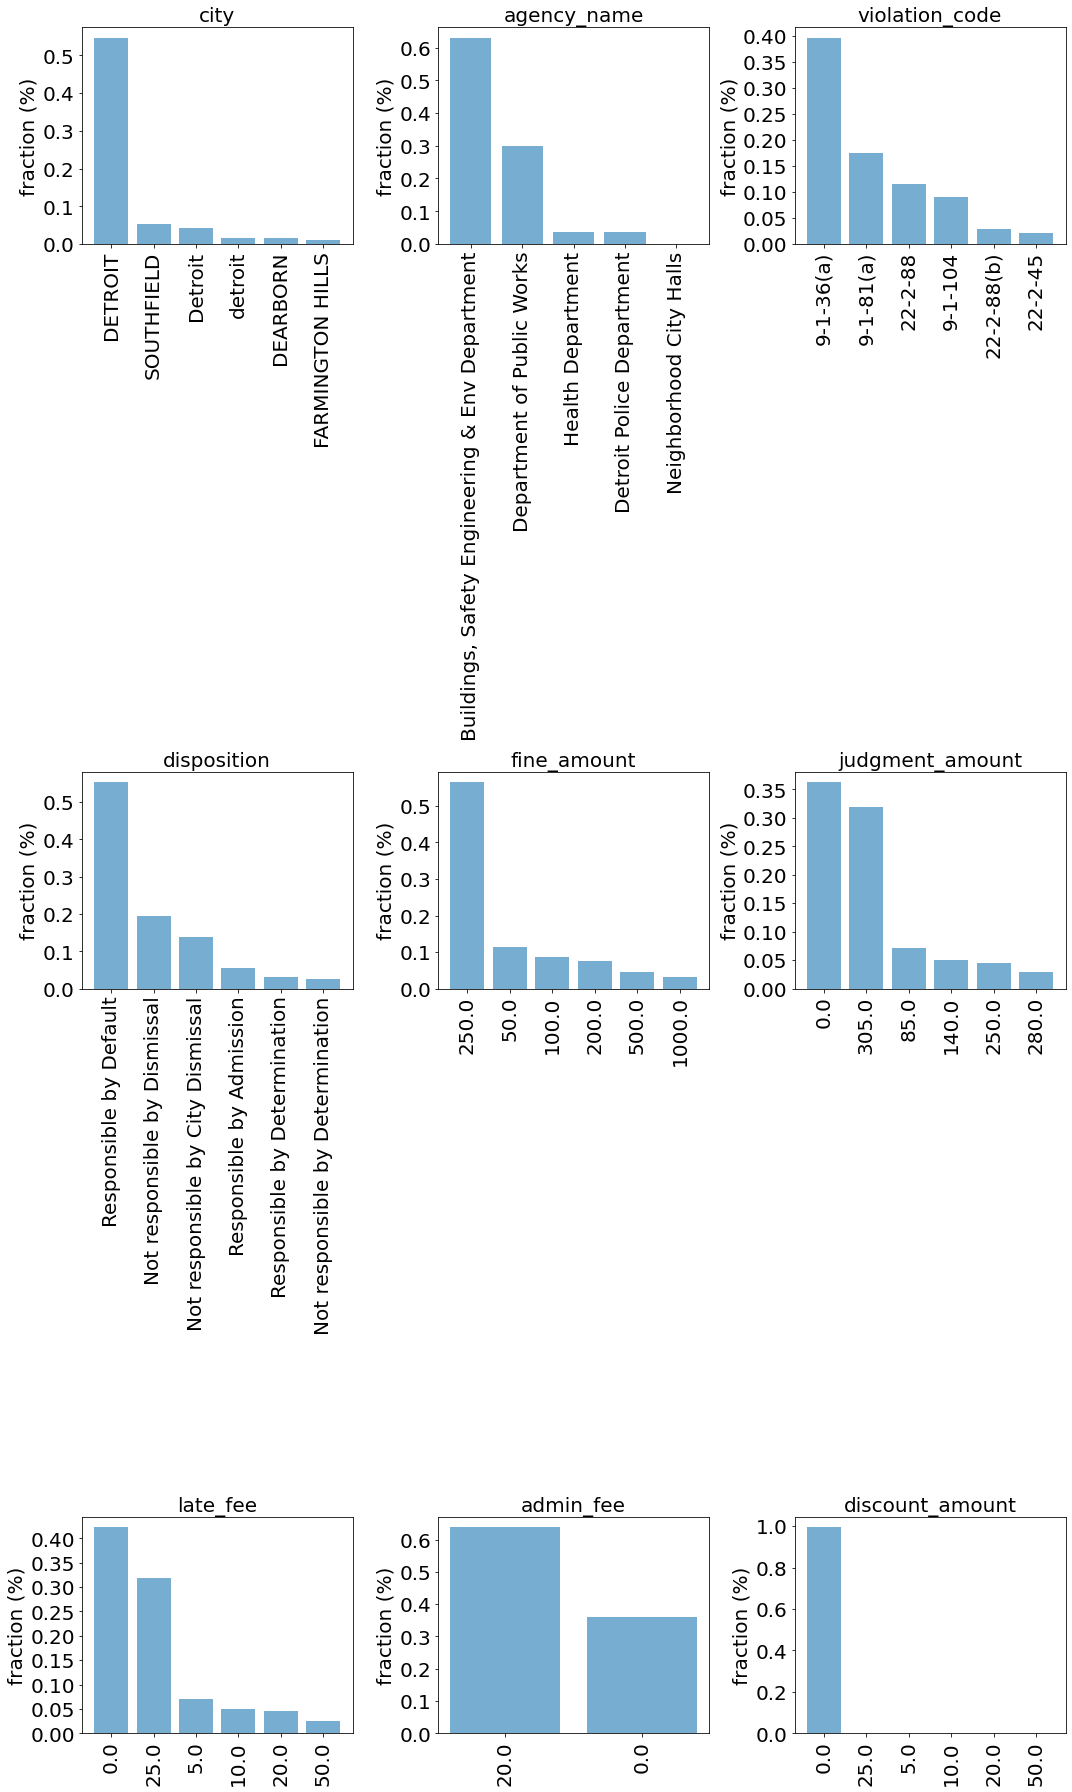

In [13]:
plt.subplots(3, 3, figsize=(15, 25))

for i, var in enumerate(varUsed):
    #print(i+1, var)
    plt.subplot(3, 3, i+1)
    names, values = features(df_train, var, 6)
    #print(names, values)
    pop = plt.bar(range(len(values)), values, alpha=0.6)
    plt.xticks(range(len(values)), names, rotation='vertical', fontsize=20)
    plt.yticks(fontsize=20)
    plt.ylabel('fraction (%)', fontsize=20)
    plt.title(var, fontsize=20)
plt.tight_layout()

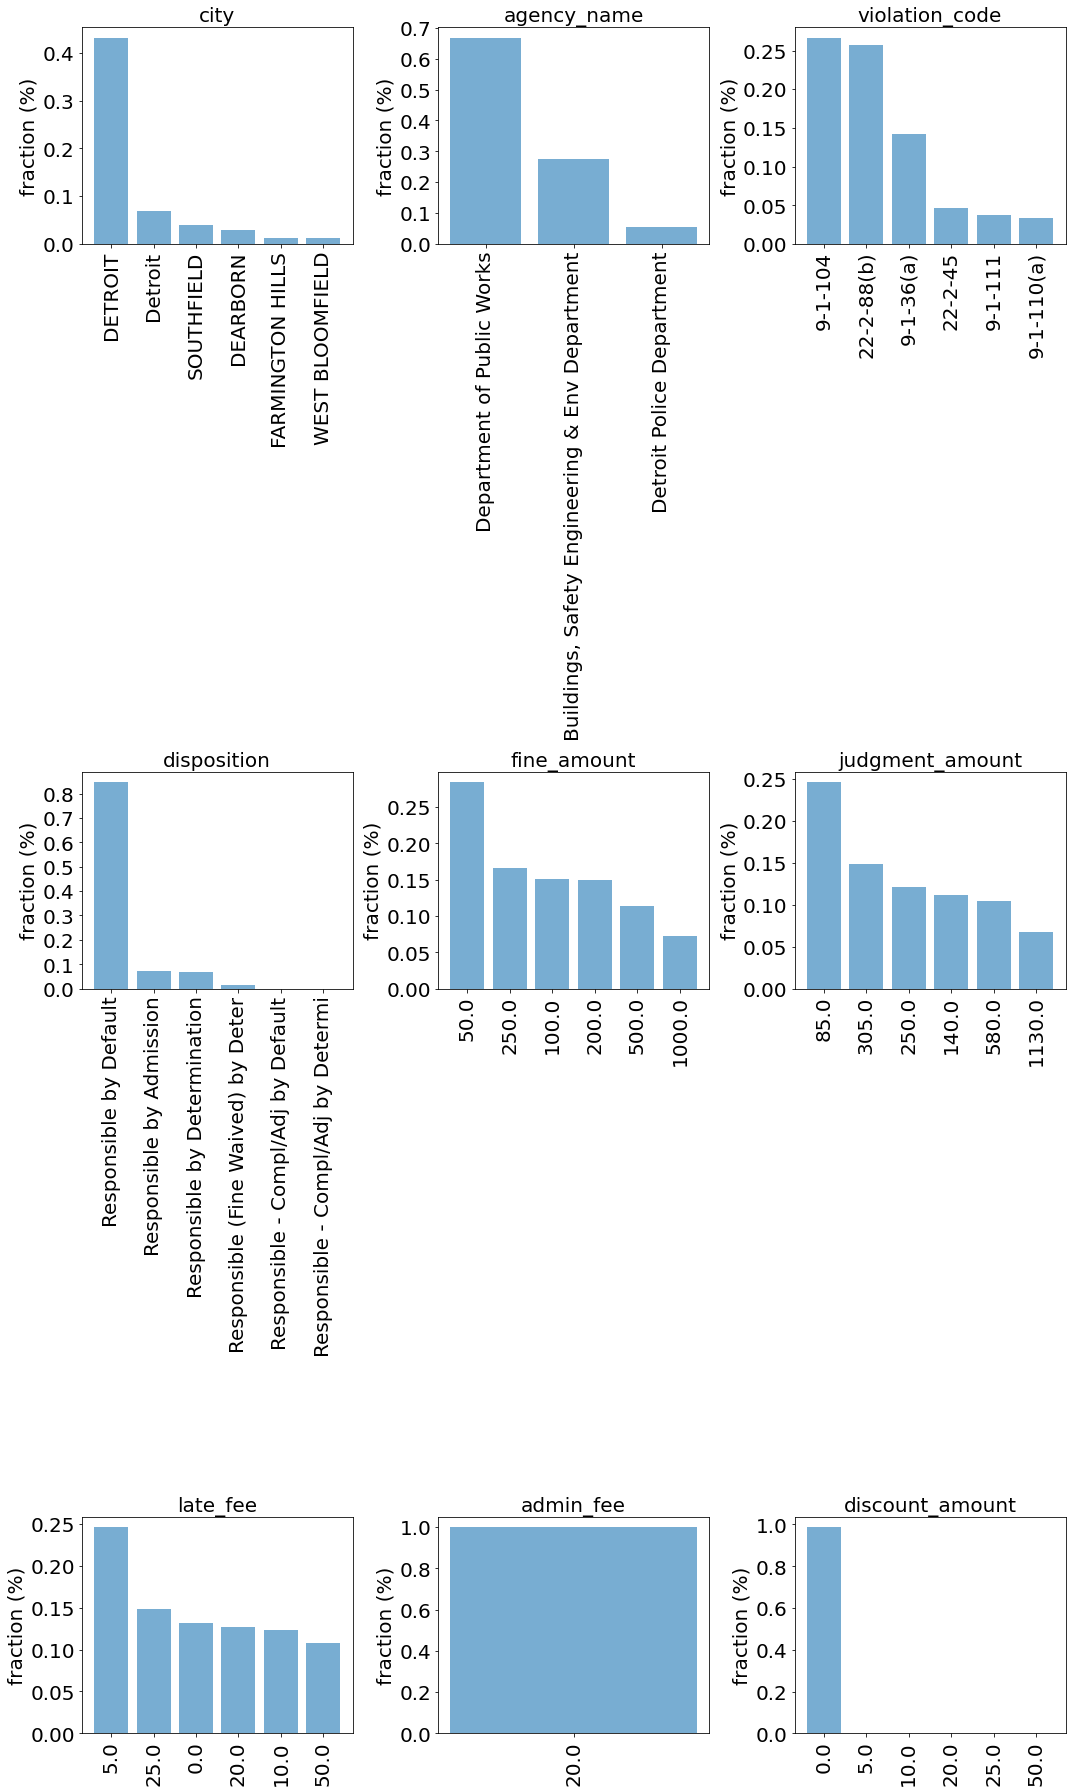

In [14]:
plt.subplots(3, 3, figsize=(15, 25))

for i, var in enumerate(varUsed):
    #print(i+1, var)
    plt.subplot(3, 3, i+1)
    names, values = features(df_test, var, 6)
    #print(names, values)
    pop = plt.bar(range(len(values)), values, alpha=0.6)
    plt.xticks(range(len(values)), names, rotation='vertical', fontsize=20)
    plt.yticks(fontsize=20)
    plt.ylabel('fraction (%)', fontsize=20)
    plt.title(var, fontsize=20)
plt.tight_layout()

In [15]:
def plot_Comp_train_test(plotVar, titleName, plotShowNumsorted=30, plotkind='bar', figsize=(18,3.2)):

    plt.subplots(1, 2, figsize=(18, 5))
    
    plt.subplot(1, 2, 1)
    yvalue = df_train[plotVar].value_counts()
    (yvalue[:plotShowNumsorted]/df_train.shape[0]).plot(kind="bar", alpha=0.6)
    plt.title(titleName+' (training set)')
    
    plt.subplot(1, 2, 2)
    yvalue = df_test[plotVar].value_counts()
    (yvalue[:plotShowNumsorted]/df_test.shape[0]).plot(kind="bar", alpha=0.6)
    plt.title(titleName+' (test set)')
    
    return plt

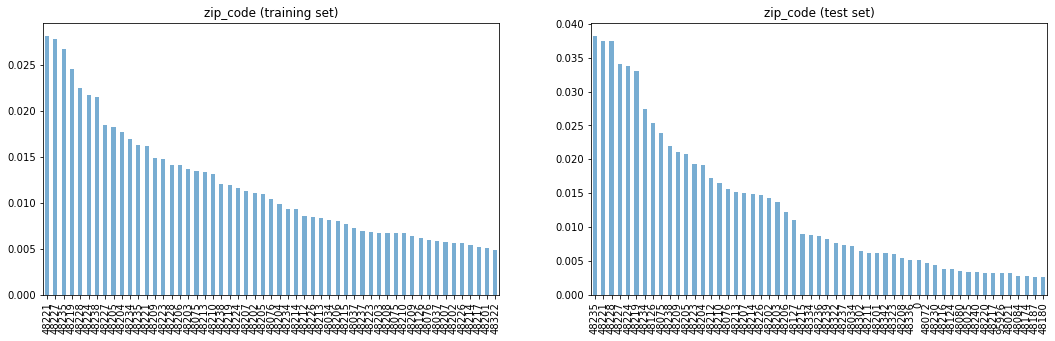

In [16]:
plot_Comp_train_test('zip_code', 'zip_code', plotShowNumsorted=55, figsize=(20,3.2));

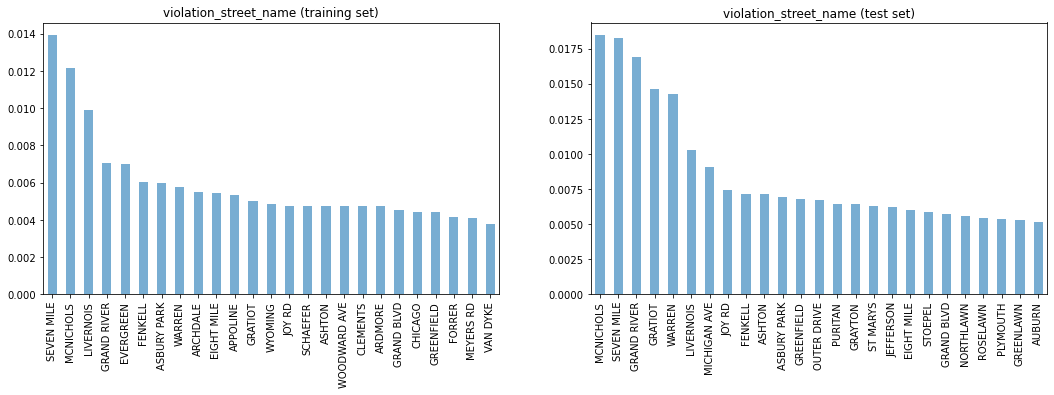

In [17]:
plot_Comp_train_test('violation_street_name', 'violation_street_name', plotShowNumsorted=25);

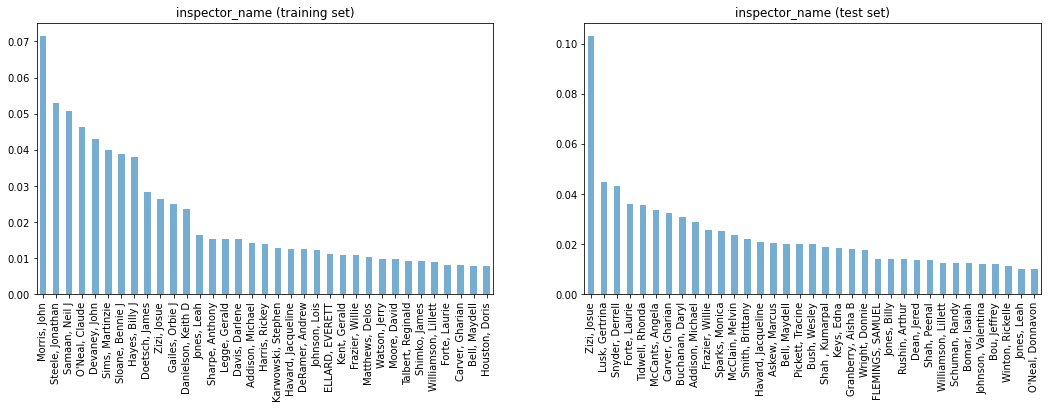

In [18]:
plot_Comp_train_test('inspector_name', 'inspector_name', plotShowNumsorted=35);

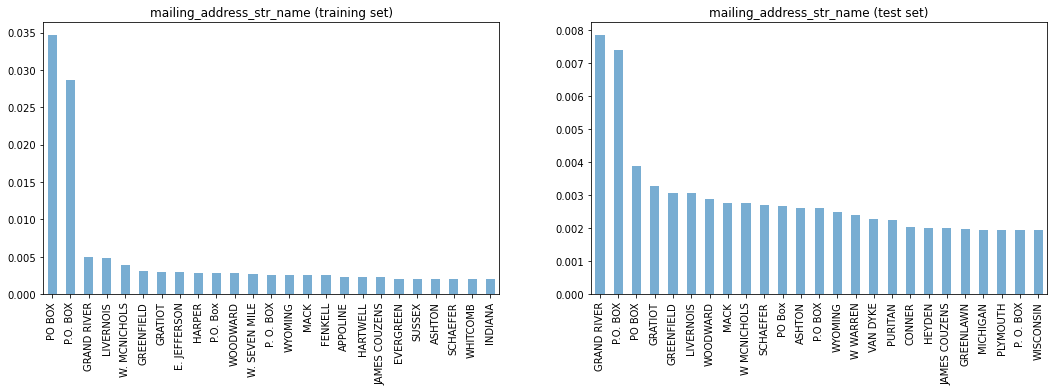

In [19]:
plot_Comp_train_test('mailing_address_str_name', 'mailing_address_str_name', plotShowNumsorted=25);

#### d). How many people pay their bill?

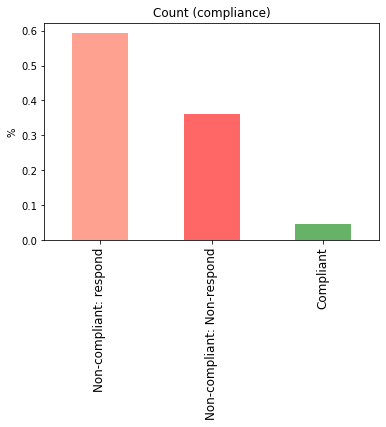

In [20]:
df_train['compliance'].fillna(-1, inplace=True)
yvalue = df_train['compliance'].value_counts()

fig, ax = plt.subplots()
(yvalue[:]/df_train.shape[0]).plot(kind="bar", alpha=0.6, title='Count (compliance)', color=['tomato', 'red', 'green'])

labels = ['Non-compliant: respond', 'Non-compliant: Non-respond', 'Compliant']

ax.set_xticklabels(labels,fontsize=12)
ax.set_ylabel('%');

#Null = non-compliant
# 0 = Responsible, non-compliant
# 1 = Responsible, compliant
# All tickets where the violators were found not responsible are not considered in test dataset.

# Save the figure and show
plt.savefig('plots/classRatio.png')

In [21]:
df_train['compliance'].value_counts()/df_train.shape[0]

 0.0    0.592407
-1.0    0.361262
 1.0    0.046331
Name: compliance, dtype: float64

### 4). Data Processing: Convert textual into numerical values 

In [22]:
#fill_mostFreq = lambda x: x.fillna(x.value_counts().index[0])
#var in varUsed 
#for df_train[var].value_counts().index[0]

#if df_train.city.isnull().sum() > 0: 
#    df_train = df_train.apply(fill_mostFreq)
#if df_test.city.isnull().sum() > 0: 
#    df_test = df_test.apply(fill_mostFreq)

df_test['city'].fillna(df_train['city'].value_counts().index[0], inplace=True)

In [23]:
#0 city  
#train: ['DETROIT', 'SOUTHFIELD', 'Detroit', 'detroit', 'DEARBORN', 'FARMINGTON HILLS'] 
#[0.54707438095770777, 0.053678297763537428, 0.041932674406526413, 0.016711545068835744, 0.014530215016819413, 0.009304611155945124]
#test: ['DETROIT', 'Detroit', 'SOUTHFIELD', 'DEARBORN', 'FARMINGTON HILLS', 'WEST BLOOMFIELD'] 
#[0.43209127719217716, 0.068326748741823901, 0.040425566793986983, 0.02963885837937083, 0.012671923411091621, 0.011475221717676759]

def convt_city(convtStr):
    if convtStr in ['DETROIT', 'Detroit', 'detroit']:
        return 1
    elif convtStr in 'SOUTHFIELD':
        return 2
    elif convtStr in 'DEARBORN':
        return 3
    else:
        return 4
    
df_train['city'] = df_train['city'].apply(convt_city)
df_test['city'] = df_test['city'].apply(convt_city)

In [24]:
#1 agency_name
#['Buildings, Safety Engineering & Env Department', 'Department of Public Works', 'Health Department', 'Detroit Police Department', 'Neighborhood City Halls'] 
#[0.63036443393286612, 0.29850263277748035, 0.035568464199819419, 0.035556478869863288, 7.9902199707557944e-06]
#['Department of Public Works', 'Buildings, Safety Engineering & Env Department', 'Detroit Police Department'] 
#[0.66771036540384587, 0.2759299027884789, 0.056359731807675284]

def convt_agency_name(convtStr):
    if convtStr in 'Buildings, Safety Engineering & Env Department':
        return 1
    elif convtStr in 'Department of Public Works':
        return 2
    elif convtStr in 'Health Department':
        return 3
    elif convtStr in 'Detroit Police Department':
        return 4
    else:
        return 5
    
df_train['agency_name'] = df_train['agency_name'].apply(convt_agency_name)
df_test['agency_name'] = df_test['agency_name'].apply(convt_agency_name)

In [25]:
#2 violation_code
#['9-1-36(a)', '9-1-81(a)', '22-2-88', '9-1-104', '22-2-88(b)', '22-2-45'] 
#[0.39587944356108123, 0.17367142617436257, 0.11473955878005321, 0.090033798630476294, 0.02891660607416522, 0.02154962326112838]
#['9-1-104', '22-2-88(b)', '9-1-36(a)', '22-2-45', '9-1-111', '9-1-110(a)'] 
#[0.26653661415386631, 0.25735643677972492, 0.14185013360436713, 0.046622186521532431, 0.03681906853986, 0.032868313634202721]

def convt_violation_code(convtStr):
    if convtStr == '9-1-36(a)':
        return 1
    elif convtStr == '9-1-81(a)':
        return 2
    elif convtStr == '22-2-88':
        return 3
    elif convtStr == '9-1-104':
        return 4
    elif convtStr == '22-2-88(b)':
        return 5
    elif convtStr == '22-2-45':
        return 6
    else:
        return 7

df_train['violation_code'] = df_train['violation_code'].apply(convt_violation_code)
df_test['violation_code'] = df_test['violation_code'].apply(convt_violation_code)

In [26]:
#4 disposition
#['Responsible by Default', 'Not responsible by Dismissal', 'Not responsible by City Dismissal', 
#'Responsible by Admission', 'Responsible by Determination', 'Not responsible by Determination'] 
#[0.5526835153771783, 0.19454188073797671, 0.13743577860698505, 0.054737001909662575, 0.030538620728228646, 0.026523535192923862]
#['Responsible by Default', 'Responsible by Admission', 'Responsible by Determination', 'Responsible (Fine Waived) by Deter', 'Responsible - Compl/Adj by Default', 'Responsible - Compl/Adj by Determi'] 
#[0.84592055867936589, 0.073506991688660844, 0.067605449090998512, 0.012803068802150784, 9.8359043294372222e-05, 3.2786347764790741e-05]

def convt_disposition(convtStr):
    if convtStr in 'Responsible by Default':
        return 1
    elif 'Dismissal' in convtStr:
        return 2
    elif convtStr in 'Responsible by Admission':
        return 3
    elif convtStr in 'Responsible by Determination':
        return 4
    else:
        return 5

df_train['disposition'] = df_train['disposition'].apply(convt_disposition)
df_test['disposition'] = df_test['disposition'].apply(convt_disposition)

In [27]:
def convt_discount(convtNum):
    if convtNum > 0:
        return 1
    else:
        return 0
    
df_train['discount_amount'] = df_train['discount_amount'].apply(convt_discount)
df_test['discount_amount'] = df_test['discount_amount'].apply(convt_discount)

There are some variables that could possible be convert to numerical values:  
 - 'zip_code'
 - 'inspector_name'
 - 'violation_street_name'
 - 'mailing_address_str_name' 
 
Here I just made the conversion for those above. 

In [28]:
df_train['discount_amount'].value_counts()

0    249126
1      1180
Name: discount_amount, dtype: int64

In [29]:
df_test['discount_amount'].value_counts()

0    60239
1      762
Name: discount_amount, dtype: int64

### 5). Distributions of Paid/NoPaid on variables

In [30]:
df_true = df_train[df_train.compliance == 1]
df_false = df_train[df_train.compliance != 1]

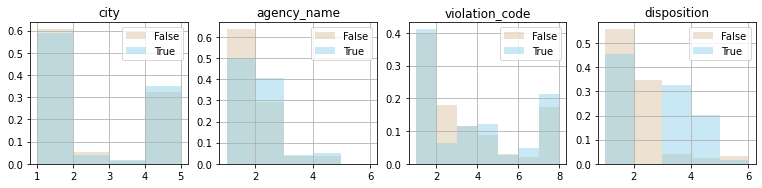

In [46]:
varPlot1 = ['city', 'agency_name', 'violation_code', 'disposition']

plt.subplots(1, 4, figsize=(13, 2.6))

for i, var in enumerate(varPlot1):
    plt.subplot(1, 4, i+1)
    nbins = df_train[var].nunique()
    df_false[var].hist(bins=nbins, range=[1, 1+nbins], alpha=0.4, density=True, color='tan', label='False')
    df_true[var].hist(bins=nbins, range=[1, 1+nbins], alpha=0.45, density=True, color='skyblue', label='True')
    plt.title(var)
    plt.legend()
    
plt.savefig('plots/variables_textual.png')

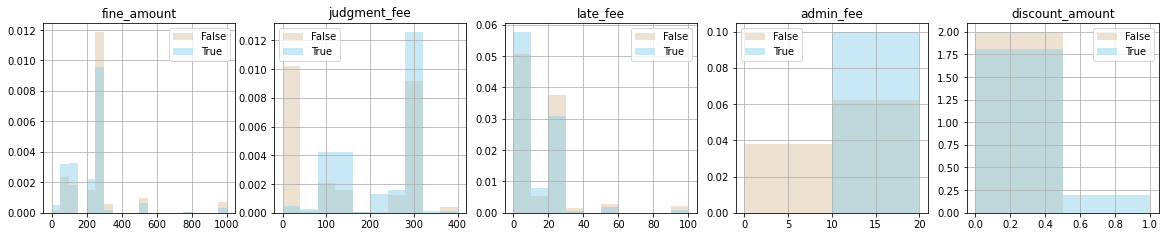

In [32]:
# Draw one-by-one because the binning needs to be adjust:

#varPlot2 = ['fine_amount', 'late_fee', 'judgment_amount', 'balance_due']
plt.subplots(1, 5, figsize=(20, 3.5))

plt.subplot(1, 5, 1)
df_false['fine_amount'].hist(bins=20, range=[0, 1000], alpha=0.4, density=True, color='tan', label='False')
df_true['fine_amount'].hist(bins=20, range=[0, 1000], alpha=0.45, density=True, color='skyblue', label='True')
plt.title('fine_amount')
plt.legend()

plt.subplot(1, 5, 2)
df_false['judgment_amount'].hist(bins=10, range=[0, 400], alpha=0.4, density=True, color='tan', label='False')
df_true['judgment_amount'].hist(bins=10, range=[0, 400], alpha=0.45, density=True, color='skyblue', label='True')
plt.title('judgment_fee')
plt.legend()

plt.subplot(1, 5, 3)
df_false['late_fee'].hist(bins=10, range=[0, 100], alpha=0.4, density=True, color='tan', label='False')
df_true['late_fee'].hist(bins=10, range=[0, 100], alpha=0.45, density=True, color='skyblue', label='True')
plt.title('late_fee')
plt.legend()

plt.subplot(1, 5, 4)
df_false['admin_fee'].hist(bins=2, range=[0, 20], alpha=0.4, density=True, color='tan', label='False')
df_true['admin_fee'].hist(bins=2, range=[0, 20], alpha=0.45, density=True, color='skyblue', label='True')
plt.title('admin_fee')
plt.legend()

plt.subplot(1, 5, 5)
df_false['discount_amount'].hist(bins=2, alpha=0.4, density=True, color='tan', label='False')
df_true['discount_amount'].hist(bins=2, alpha=0.45, density=True, color='skyblue', label='True')
plt.title('discount_amount')
plt.legend();

#### Merge class -1 to class 0 

In [33]:
df_train['compliance'].replace({-1.0:0.0}, inplace=True)

In [34]:
varModel = ['ticket_id'] + varUsed 
df_test = df_test[varModel].copy()

varModel = varModel + ['compliance']
df_train = df_train[varModel].copy()

#### Final check and ready to dump it

In [35]:
df_train.isnull().sum()

ticket_id          0
city               0
agency_name        0
violation_code     0
disposition        0
fine_amount        1
judgment_amount    0
late_fee           0
admin_fee          0
discount_amount    0
compliance         0
dtype: int64

In [36]:
df_train.shape

(250306, 11)

In [37]:
df_test.isnull().sum()

ticket_id          0
city               0
agency_name        0
violation_code     0
disposition        0
fine_amount        0
judgment_amount    0
late_fee           0
admin_fee          0
discount_amount    0
dtype: int64

In [38]:
df_test.shape

(61001, 10)

In [39]:
df_train.dropna(axis=0, inplace=True)
df_train.shape

(250305, 11)

In [40]:
df_train.isnull().sum()

ticket_id          0
city               0
agency_name        0
violation_code     0
disposition        0
fine_amount        0
judgment_amount    0
late_fee           0
admin_fee          0
discount_amount    0
compliance         0
dtype: int64

In [41]:
df_train.columns[1:-1]

Index(['city', 'agency_name', 'violation_code', 'disposition', 'fine_amount',
       'judgment_amount', 'late_fee', 'admin_fee', 'discount_amount'],
      dtype='object')

### Correlation map of selected properities

In [42]:
corr_pairs = df_train.corr().unstack()
corr_pairs_sorted = corr_pairs.sort_values(kind="quicksort")
corr_pairs_strong = corr_pairs_sorted[abs(corr_pairs_sorted) > 0.03]
print(corr_pairs_strong['compliance'])
#print(corr_pairs_strong)

fine_amount       -0.042418
late_fee          -0.032912
violation_code     0.033512
agency_name        0.049261
disposition        0.157762
admin_fee          0.165763
discount_amount    0.296428
compliance         1.000000
dtype: float64


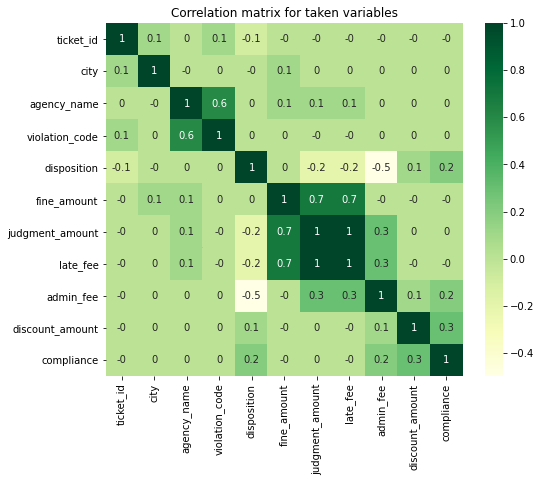

In [45]:
correlation = df_train.corr().round(1)

fig, ax = plt.subplots(1, 1, figsize=(8, 6.5))
sns.heatmap(data=correlation, annot=True, cmap="YlGn")
ax.set_title("Correlation matrix for taken variables");

plt.savefig('plots/correlationMap.png')

## Dump the pre-processed data set and ready for next step

In [44]:
df_train.to_csv(r'dataset/cleaned_train.csv', index=False)